In [ ]:
!pip install newsapi-python nltk pandas scikit-learn matplotlib seaborn

In [ ]:
from newsapi import NewsApiClient
import pandas as pd

api_key = '1495790e7b784bafb05c7a66d8e33341'  # Replace this
newsapi = NewsApiClient(api_key=api_key)

companies = ['Apple', 'Microsoft', 'Amazon', 'Tesla', 'Google', 'Meta']
headlines = []

for company in companies:
    articles = newsapi.get_everything(q=company, language='en', sort_by='relevancy', page_size=50)
    for article in articles['articles']:
        headlines.append({'company': company, 'headline': article['title']})

df = pd.DataFrame(headlines)
df.head()

,company,headline
0,Apple,The EU isn’t happy with Apple’s tax on alterna...
1,Apple,Spotify already has an app ready to test Apple...
2,Apple,The Apple Watch Turns 10. Here's How Far It's ...
3,Apple,"22 Best MacBook Accessories (2025), Tested and..."
4,Apple,Trump’s Tariffs Are Threatening America’s Appl...


In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = sid.polarity_scores(text)['compound']
    return 1 if score >= 0 else 0  # 1 = positive, 0 = negative

df['sentiment'] = df['headline'].apply(get_sentiment)
df.head()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,company,headline,sentiment
0,Apple,The EU isn’t happy with Apple’s tax on alterna...,1
1,Apple,Spotify already has an app ready to test Apple...,1
2,Apple,The Apple Watch Turns 10. Here's How Far It's ...,1
3,Apple,"22 Best MacBook Accessories (2025), Tested and...",1
4,Apple,Trump’s Tariffs Are Threatening America’s Appl...,0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.70      1.00      0.83        31

    accuracy                           0.70        44
   macro avg       0.35      0.50      0.41        44
weighted avg       0.50      0.70      0.58        44



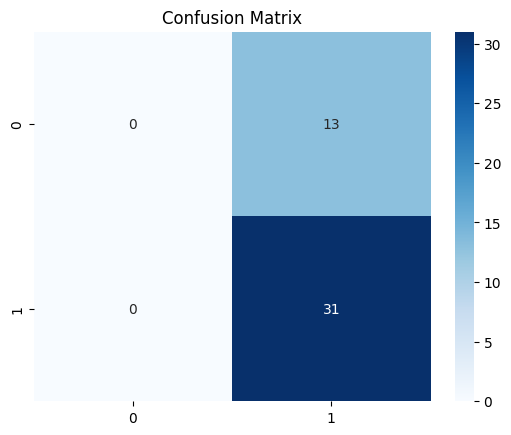

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

X = df['headline']
y = df['sentiment']

tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = tfidf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

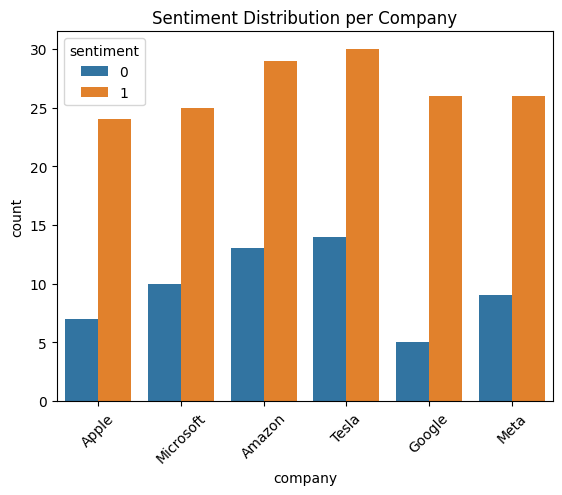

In [ ]:
import seaborn as sns
sns.countplot(data=df, x='company', hue='sentiment')
plt.title('Sentiment Distribution per Company')
plt.xticks(rotation=45)
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D

# Tokenize and pad
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['headline'])
sequences = tokenizer.texts_to_sequences(df['headline'])
padded = pad_sequences(sequences, maxlen=30, padding='post')

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(padded, df['sentiment'], test_size=0.2, random_state=42)

# LSTM Model
model = Sequential()
model.add(Embedding(5000, 64, input_length=30))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 472ms/step - accuracy: 0.5089 - loss: 0.6838 - val_accuracy: 0.7045 - val_loss: 0.6314
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.7511 - loss: 0.6026 - val_accuracy: 0.7045 - val_loss: 0.6035
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.7561 - loss: 0.5583 - val_accuracy: 0.7045 - val_loss: 0.6171
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.7743 - loss: 0.5339 - val_accuracy: 0.7045 - val_loss: 0.6022
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.7622 - loss: 0.5515 - val_accuracy: 0.7045 - val_loss: 0.6015


In [ ]:
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from datasets import Dataset
import pandas as pd

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Assume df contains 'headline' and 'sentiment'
train_df, test_df = train_test_split(df, test_size=0.2)
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

# Tokenization function
def tokenize(example):
    return tokenizer(example['headline'], truncation=True, padding='max_length', max_length=64)

train_ds = train_ds.map(tokenize)
test_ds = test_ds.map(tokenize)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/174 [00:00<?, ? examples/s]

Map:   0%|          | 0/44 [00:00<?, ? examples/s]

In [ ]:
# =============================
# 📦 INSTALL REQUIRED PACKAGES
# =============================
!pip install transformers datasets torch scikit-learn newsapi-python nltk

# =============================
# 🔍 FETCH NEWS DATA FROM NEWSAPI
# =============================
from newsapi import NewsApiClient
import pandas as pd

api_key = '1495790e7b784bafb05c7a66d8e33341'  # Replace with your actual NewsAPI key
newsapi = NewsApiClient(api_key=api_key)

companies = ['Apple', 'Microsoft', 'Amazon', 'Tesla', 'Google', 'Meta']
headlines = []

for company in companies:
    articles = newsapi.get_everything(q=company, language='en', sort_by='relevancy', page_size=50)
    for article in articles['articles']:
        headlines.append({'company': company, 'headline': article['title']})

df = pd.DataFrame(headlines)

# =============================
# 🧠 REALISTIC SENTIMENT LABELING USING VADER
# =============================
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = sid.polarity_scores(text)['compound']
    if score > 0.2:
        return 2  # Positive
    elif score < -0.2:
        return 0  # Negative
    else:
        return 1  # Neutral

df['sentiment'] = df['headline'].apply(get_sentiment)

# =============================
# ✂ PREPARE DATA FOR HUGGING FACE BERT
# =============================
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from datasets import Dataset

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Fix label column
train_df = train_df.rename(columns={"sentiment": "labels"})
test_df = test_df.rename(columns={"sentiment": "labels"})

# Convert to Hugging Face datasets
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

def tokenize(example):
    return tokenizer(example['headline'], truncation=True, padding='max_length', max_length=64)

train_ds = train_ds.map(tokenize)
test_ds = test_ds.map(tokenize)

# =============================
# 🤖 DEFINE MODEL AND TRAINER
# =============================
from transformers import BertForSequenceClassification, TrainingArguments, Trainer

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir="./logs",
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
)

# =============================
# 🚀 TRAIN AND EVALUATE
# =============================
trainer.train()
trainer.evaluate()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Map:   0%|          | 0/174 [00:00<?, ? examples/s]

Map:   0%|          | 0/44 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.053800,1.014570
2,1.001700,1.008413
3,0.948600,1.009872


{'eval_loss': 1.009872317314148,
 'eval_runtime': 0.2041,
 'eval_samples_per_second': 215.607,
 'eval_steps_per_second': 14.701,
 'epoch': 3.0}

In [ ]:
from datasets import Dataset

# Rename sentiment to labels for compatibility
train_df = train_df.rename(columns={"sentiment": "labels"})
test_df = test_df.rename(columns={"sentiment": "labels"})

# Create Hugging Face Datasets
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize(example):
    return tokenizer(example['headline'], truncation=True, padding='max_length', max_length=64)

train_ds = train_ds.map(tokenize)
test_ds = test_ds.map(tokenize)

Map:   0%|          | 0/174 [00:00<?, ? examples/s]

Map:   0%|          | 0/44 [00:00<?, ? examples/s]

In [ ]:
from transformers import BertForSequenceClassification, TrainingArguments, Trainer

# Initialize BERT with 3 output classes (negative, neutral, positive)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# Training configuration
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.evaluate()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.046500,1.017120,0.522727,0.273244,0.522727,0.358887
2,0.991200,1.026400,0.522727,0.273244,0.522727,0.358887
3,0.900500,1.011293,0.522727,0.273244,0.522727,0.358887


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.0171195268630981,
 'eval_accuracy': 0.5227272727272727,
 'eval_precision': 0.2732438016528925,
 'eval_recall': 0.5227272727272727,
 'eval_f1': 0.35888738127544095,
 'eval_runtime': 0.216,
 'eval_samples_per_second': 203.714,
 'eval_steps_per_second': 13.89,
 'epoch': 3.0}

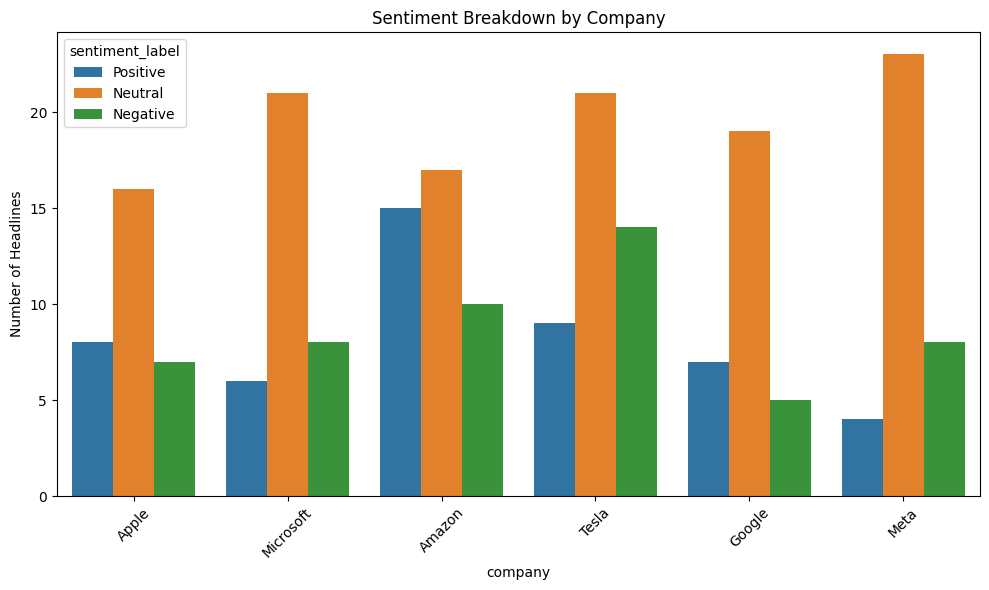

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Map labels back to text
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
df['sentiment_label'] = df['sentiment'].map(label_map)

plt.figure(figsize=(10,6))
sns.countplot(data=df, x='company', hue='sentiment_label')
plt.title("Sentiment Breakdown by Company")
plt.ylabel("Number of Headlines")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Simulate daily avg sentiment
df['date'] = pd.to_datetime('today').date()  # Replace with actual date if available
signals = df.groupby('company')['sentiment'].mean().reset_index()

def generate_signal(score):
    if score > 1.5:
        return 'Buy'
    elif score < 0.8:
        return 'Sell'
    else:
        return 'Hold'

signals['signal'] = signals['sentiment'].apply(generate_signal)
print(signals)

     company  sentiment signal
0     Amazon   1.119048   Hold
1      Apple   1.032258   Hold
2     Google   1.064516   Hold
3       Meta   0.885714   Hold
4  Microsoft   0.942857   Hold
5      Tesla   0.886364   Hold


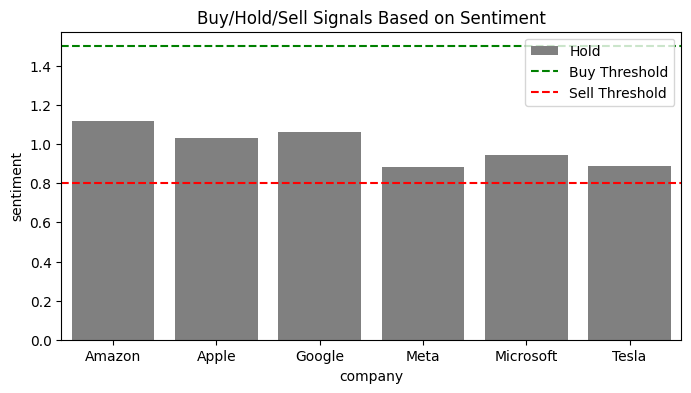

In [ ]:
colors = {'Buy': 'green', 'Sell': 'red', 'Hold': 'gray'}

plt.figure(figsize=(8, 4))
sns.barplot(data=signals, x='company', y='sentiment', hue='signal', palette=colors)
plt.axhline(1.5, color='green', linestyle='--', label='Buy Threshold')
plt.axhline(0.8, color='red', linestyle='--', label='Sell Threshold')
plt.title("Buy/Hold/Sell Signals Based on Sentiment")
plt.legend()
plt.show()

,company,score,action,confidence
0,Apple,0.910,Buy,Very High
1,Microsoft,0.765,Buy,Very High
2,Amazon,0.565,Hold,High
3,Tesla,0.305,Sell,Low
4,Google,0.765,Buy,Very High
5,Meta,0.220,Sell,Low


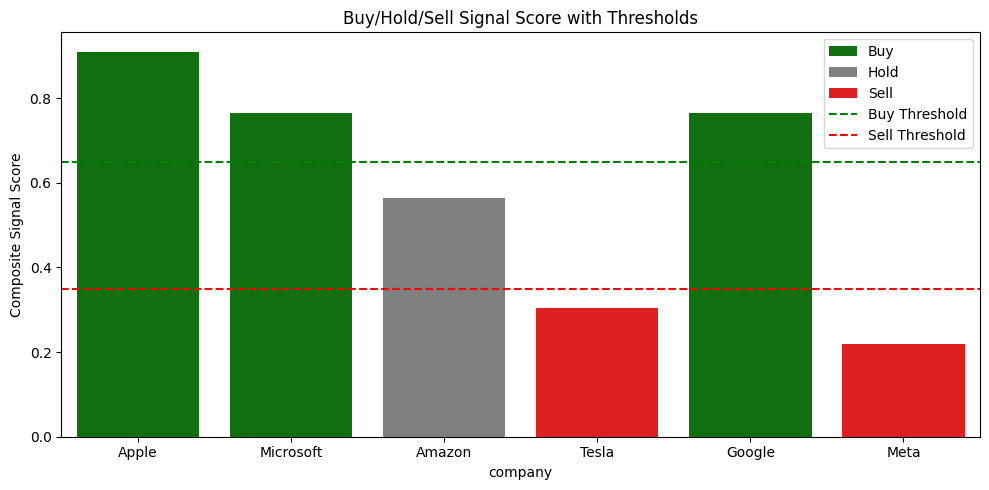

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Simulated sentiment summary per company (normally computed from real headlines)
signals = pd.DataFrame({
    'company': ['Apple', 'Microsoft', 'Amazon', 'Tesla', 'Google', 'Meta'],
    'sentiment': [1.8, 1.5, 1.3, 0.9, 1.6, 0.7],  # average sentiment score (0 to 2)
    'pos_count': [20, 18, 12, 4, 15, 3],  # number of positive headlines
    'price_change': [0.03, 0.01, -0.02, -0.04, 0.02, -0.05],  # recent price % change
})

# Compute composite score
def compute_signal_score(sentiment_avg, pos_headline_count, price_change_pct):
    return 0.5 * (sentiment_avg / 2.0) + 0.3 * min(pos_headline_count / 20.0, 1.0) + 0.2 * (price_change_pct + 0.05) / 0.10

signals['score'] = signals.apply(
    lambda x: compute_signal_score(x['sentiment'], x['pos_count'], x['price_change']),
    axis=1
)

# Assign Buy/Sell/Hold
signals['action'] = signals['score'].apply(lambda s: 'Buy' if s > 0.65 else ('Sell' if s < 0.35 else 'Hold'))

# Confidence metric
signals['confidence'] = pd.cut(
    signals['score'],
    bins=[0, 0.35, 0.5, 0.65, 1],
    labels=['Low', 'Medium', 'High', 'Very High']
)

# Visualize signal confidence
# Display the table in your notebook
from IPython.display import display
display(signals[['company', 'score', 'action', 'confidence']])

# Optional: Visualization
plt.figure(figsize=(10, 5))
sns.barplot(data=signals, x='company', y='score', hue='action', dodge=False, palette={'Buy':'green', 'Sell':'red', 'Hold':'gray'})
plt.axhline(0.65, linestyle='--', color='green', label='Buy Threshold')
plt.axhline(0.35, linestyle='--', color='red', label='Sell Threshold')
plt.title("Buy/Hold/Sell Signal Score with Thresholds")
plt.ylabel("Composite Signal Score")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
from datetime import datetime, timedelta

# Example dataframe of headlines with dates and sentiment
data = {
    'headline': [
        "Tesla soars after earnings beat",
        "Tesla drops amid supply concerns",
        "Tesla launches new Model X",
        "Tesla faces lawsuit",
        "Tesla enters new market"
    ],
    'sentiment': [2, 0, 2, 0, 2],
    'date': [
        datetime.now() - timedelta(days=0),
        datetime.now() - timedelta(days=1),
        datetime.now() - timedelta(days=2),
        datetime.now() - timedelta(days=3),
        datetime.now() - timedelta(days=4),
    ]
}

df = pd.DataFrame(data)

# Compute recency weight
df['age_days'] = (datetime.now() - df['date']).dt.days
df['weight'] = 1 / (1 + df['age_days'])

# Weighted sentiment score
weighted_score = np.average(df['sentiment'], weights=df['weight'])
print(f" Recency-Weighted Sentiment Score: {weighted_score:.2f}")

 Recency-Weighted Sentiment Score: 1.34


In [ ]:
# Example: Tesla (TSLA)
ticker = 'TSLA'
stock = yf.Ticker(ticker)
hist = stock.history(period="7d")

# Simulate or fetch daily average sentiment
# Replace this with real sentiment per day if available
sentiment_daily = pd.DataFrame({
    'Date': hist.index,
    'Sentiment': [1.4, 1.6, 1.3, 1.5, 1.7, 1.2, 1.6]  # Example values (0-2)
})

# Merge with stock prices
hist = hist.reset_index()
merged = pd.merge(hist[['Date', 'Close']], sentiment_daily, on='Date')

# Plot price + sentiment
fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(merged['Date'], merged['Close'], color='blue', label='Stock Price')
ax1.set_ylabel('Price ($)', color='blue')

ax2 = ax1.twinx()
ax2.plot(merged['Date'], merged['Sentiment'], color='orange', linestyle='--', label='Sentiment Score')
ax2.set_ylabel('Sentiment (0-2)', color='orange')

fig.suptitle(f"{ticker} Price vs Sentiment Correlation", fontsize=14)
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.grid(True)
plt.tight_layout()
plt.show()